# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'tuning_train_data_bm.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [3]:
def feature_engineering(df):
    
#     #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
#     df.sort_values(by=['userID','assessmentItemID', 'Timestamp'], inplace=True)
    
#     #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
#     df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
#     df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
#     df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

#     # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
#     # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

#     cat_features = ['userID','assessmentItemID','testId', 'KnowledgeTag']         
    cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','Category','Number', 'hour', 'weekday', 
                    'prob_mean_cate', 'average_user_correct_cate', 'moving_average_user_correct', 'past_user_prob_count']
    
    for i in enumerate (cat_features) : 
        ca = i[1] 
        df[ca] = df[ca].astype('category') 

    return df

In [4]:
df = feature_engineering(df)
df.head()

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,...,0.6,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,...,0.6,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,...,0.9,0,0.0,0.0,2,2.0,1.0,1,1.0,1.0
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,...,0.9,0,0.0,0.0,3,3.0,1.0,2,2.0,1.0
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,...,1.0,0,0.0,0.0,4,4.0,1.0,3,3.0,1.0


## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']
# FEATS = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag']
# FEATS = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag', 'hour', 'weekday', 
#          'average_prob_correct_total', 'past_user_prob_count']
FEATS = ['average_user_test_correct', 'prob_mean', 'test_mean', 'tag_mean', 'solTime']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [7]:
!pip install lightgbm

In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [9]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [10]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=500,
                    early_stopping_rounds=100
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1335563, number of negative: 704174
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 2039737, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654772 -> initscore=0.640083
[LightGBM] [Info] Start training from score 0.640083
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.47085	valid_1's binary_logloss: 0.516255
[200]	training's binary_logloss: 0.468981	valid_1's binary_logloss: 0.516083
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.470168	valid_1's binary_logloss: 0.515914
VALID AUC : 0.8264226105667181 ACC : 0.7352941176470589



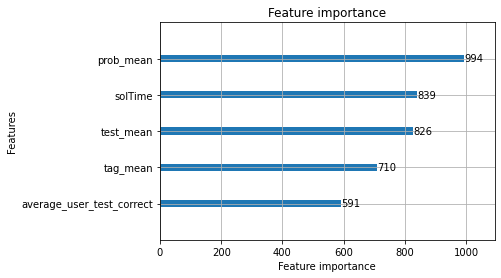

In [11]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [12]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'tuning_test_data_bm.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [13]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [14]:
# SAVE OUTPUT
output_dir = 'lgbm_output/'
write_path = os.path.join(output_dir, "average_user_test_correct+prob_mean+test_mean+tag_mean+solTime.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : lgbm_output/average_user_test_correct+prob_mean+test_mean+tag_mean+solTime.csv
